# Data preparation

In [1]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp

from segmentation import Dataset
from segmentation import SolarModel

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

/home/as1233/miniconda3/envs/solar/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper Functions

In [2]:
# Data augmentation

# Training set images augmentation
def get_training_augmentation(tile_size):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.2, rotate_limit=15, shift_limit=0.1, p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=tile_size, min_width=tile_size, always_apply=True),
        A.RandomCrop(height=tile_size, width=tile_size, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

# Validation set images augmentation
def get_validation_augmentation(tile_size):
    """Ensure validation images are correctly sized."""
    test_transform = [
        A.PadIfNeeded(min_height=tile_size, min_width=tile_size, always_apply=True),
    ]
    return A.Compose(test_transform)


# Data visualization

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()
    

In [3]:
CAL_DATA_DIR = "/home/as1233/SolarDetection/dataset"
CP_DATA_DIR = "/home/as1233/data/cape_town"

cal_x_train_dir = os.path.join(CAL_DATA_DIR, 'train/images')
cal_y_train_dir = os.path.join(CAL_DATA_DIR, 'train/masks')

cal_x_valid_dir = os.path.join(CAL_DATA_DIR, 'val/images')
cal_y_valid_dir = os.path.join(CAL_DATA_DIR, 'val/masks')

cal_x_test_dir = os.path.join(CAL_DATA_DIR, 'test/images')
cal_y_test_dir = os.path.join(CAL_DATA_DIR, 'test/masks')

cal_tile_size = 128



cp_x_train_dir = os.path.join(CP_DATA_DIR, 'train/images')
cp_y_train_dir = os.path.join(CP_DATA_DIR, 'train/masks')

cp_x_valid_dir = os.path.join(CP_DATA_DIR, 'val/images')
cp_y_valid_dir = os.path.join(CP_DATA_DIR, 'val/masks')

cp_x_test_dir = os.path.join(CP_DATA_DIR, 'test/images')
cp_y_test_dir = os.path.join(CP_DATA_DIR, 'test/masks')

cp_tile_size = 896

Let's visualize the california dataset

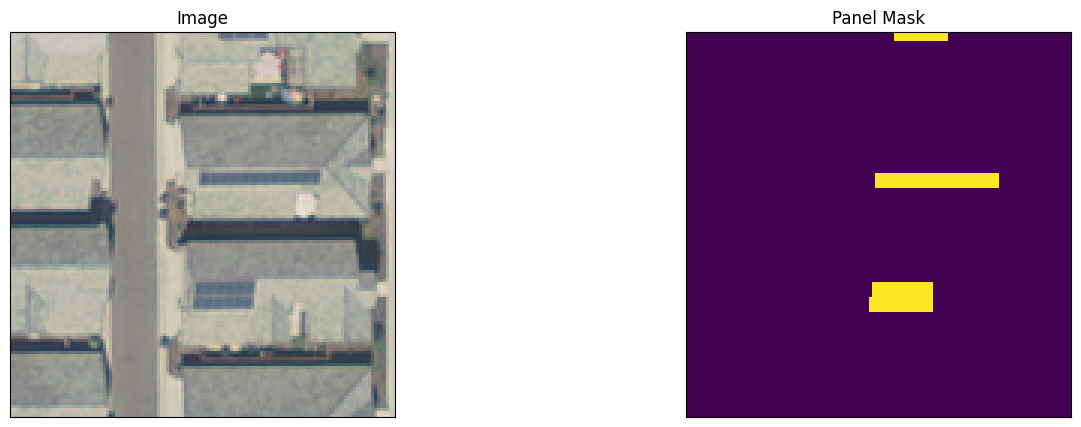

In [4]:
cal_dataset = Dataset(cal_x_train_dir, cal_y_train_dir, classes=["panel"])
# get some sample
image, mask = cal_dataset[0]
visualize(
    image=image,
    panel_mask=mask.squeeze(),
)

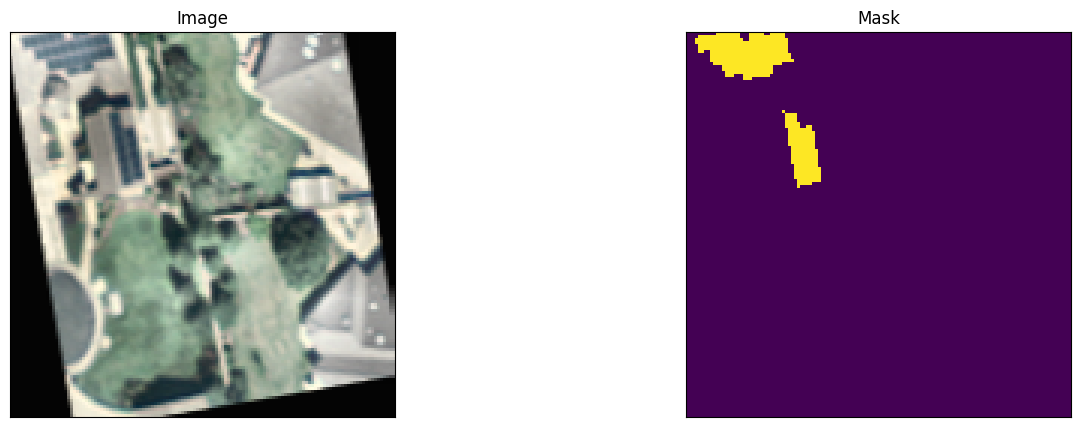

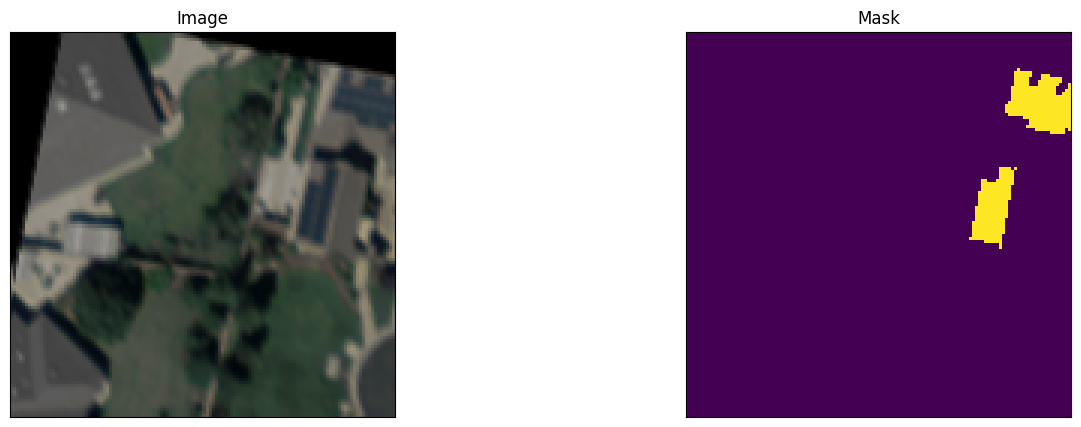

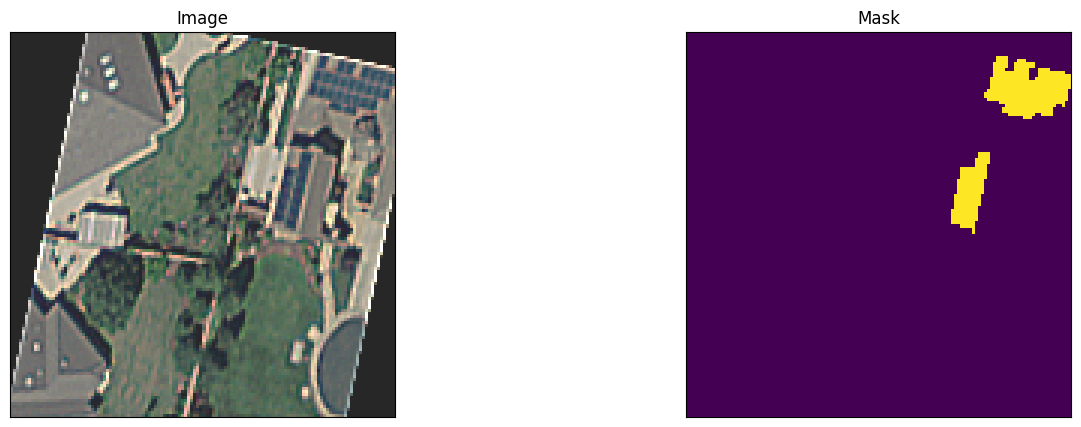

In [5]:
# Visualize resulted augmented images and masks
cal_augmented_dataset = Dataset(
    cal_x_train_dir,
    cal_y_train_dir,
    augmentation=get_training_augmentation(cal_tile_size),
    classes=["panel"],
)

# visualize same image with different random transforms
for i in range(3):
    image, mask = cal_augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

Let's visualize the cape town dataset

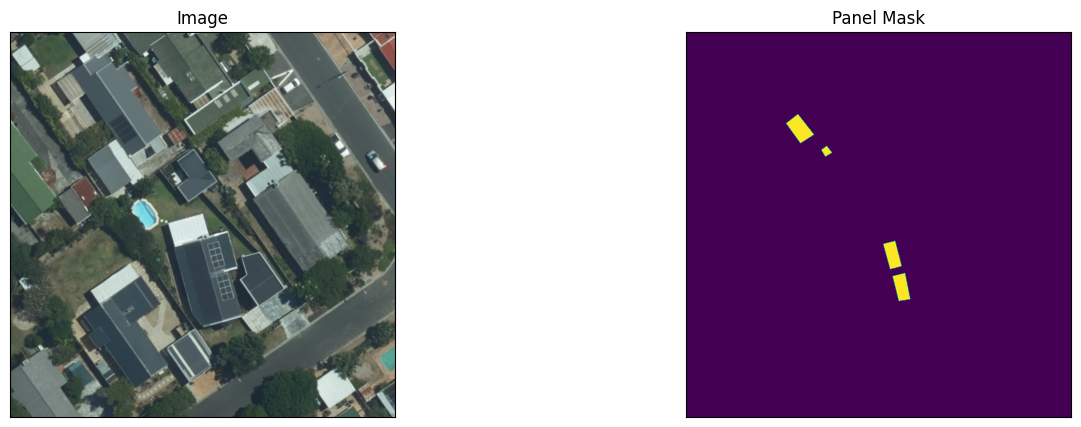

In [5]:
cp_dataset = Dataset(cp_x_train_dir, cp_y_train_dir, classes=["panel"])
# get some sample
image, mask = cp_dataset[10]
visualize(
    image=image,
    panel_mask=mask.squeeze(),
)

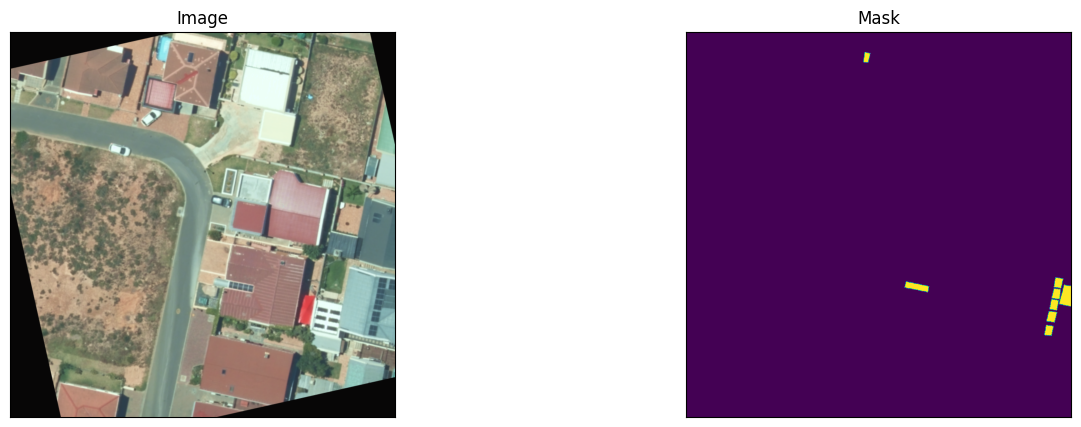

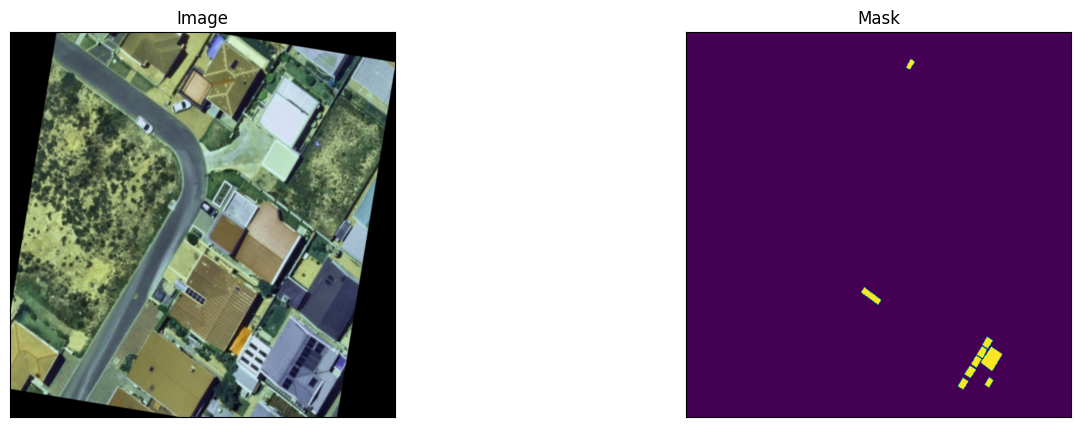

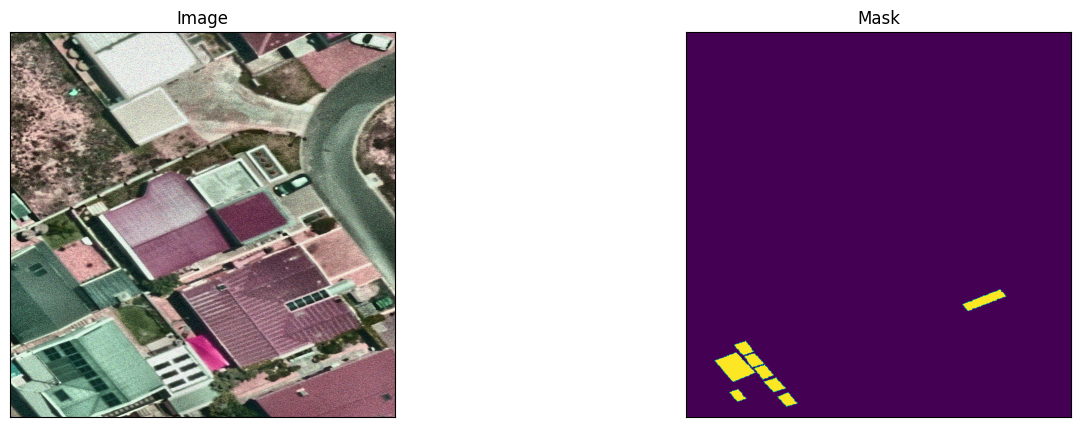

In [6]:
# Visualize resulted augmented images and masks
cp_augmented_dataset = Dataset(
    cp_x_train_dir,
    cp_y_train_dir,
    augmentation=get_training_augmentation(cp_tile_size),
    classes=["panel"],
)

# visualize same image with different random transforms
for i in range(3):
    image, mask = cp_augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

# Training

## Training with California dataset

In [8]:
CLASSES = ["solar_panel"]

cal_train_dataset = Dataset(
    cal_x_train_dir,
    cal_y_train_dir,
    augmentation=get_training_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_valid_dataset = Dataset(
    cal_x_valid_dir,
    cal_y_valid_dir,
    augmentation=get_validation_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_test_dataset = Dataset(
    cal_x_test_dir,
    cal_y_test_dir,
    augmentation=get_validation_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_train_loader = DataLoader(cal_train_dataset, batch_size=32, shuffle=True, num_workers=4)
cal_valid_loader = DataLoader(cal_valid_dataset, batch_size=32, shuffle=False, num_workers=4)
cal_test_loader = DataLoader(cal_test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
EPOCHS = 15
T_MAX = EPOCHS * len(cal_train_loader) # pay attention to len here when you train with the cape town dataset
OUT_CLASSES = 1

In [10]:
model = SolarModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES, T_max=T_MAX)

In [11]:
checkpoint_callback = ModelCheckpoint(
    dirpath='/home/as1233/SolarDetection/trained_models/solar_model_checkpoint_124.ckpt',   
    filename='{epoch}-{val_loss:.2f}',  
    monitor='valid_dataset_iou',                
    save_top_k=1,                       
    mode='min',                         
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]  
)

trainer.fit(
    model,
    train_dataloaders=cal_train_loader,
    val_dataloaders=cal_valid_loader,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2024-12-04 11:26:02.661728: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 11:26:02.747880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 11:26:04.279752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------

Epoch 14: 100%|██████████| 426/426 [00:46<00:00,  9.22it/s, v_num=15, valid_per_image_iou=0.891, valid_dataset_iou=0.895, train_per_image_iou=0.840, train_dataset_iou=0.849]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 426/426 [00:46<00:00,  9.18it/s, v_num=15, valid_per_image_iou=0.891, valid_dataset_iou=0.895, train_per_image_iou=0.840, train_dataset_iou=0.849]


In [ ]:
# model = SolarModel.load_from_checkpoint(
#     checkpoint_path="/home/as1233/SolarDetection/trained_models/SolarModel/solar_model_checkpoint_124.ckpt/",
#     arch='FPN',
#     encoder_name='resnext50_32x4d',
#     in_channels=3,
#     out_classes=OUT_CLASSES,
# )

# model.eval()  

In [13]:
model.eval()

valid_metrics = trainer.validate(model, dataloaders=cal_valid_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 92/92 [00:02<00:00, 30.87it/s]
[{'valid_per_image_iou': 0.8913792371749878, 'valid_dataset_iou': 0.8954570889472961}]


In [14]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=cal_test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 92/92 [00:29<00:00,  3.07it/s]
[{'test_per_image_iou': 0.8911635875701904, 'test_dataset_iou': 0.8945603966712952}]


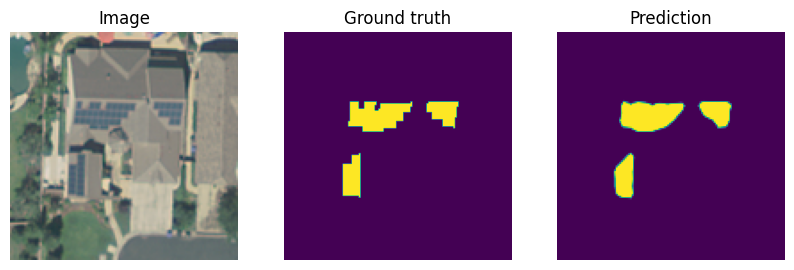

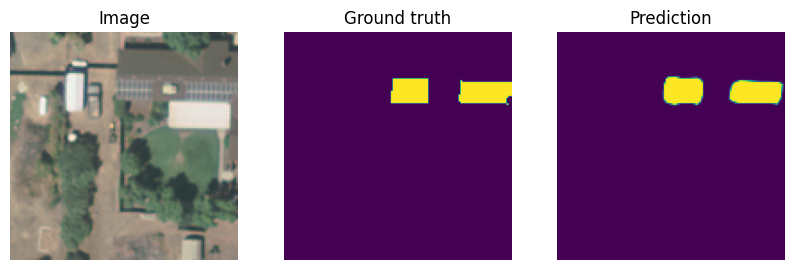

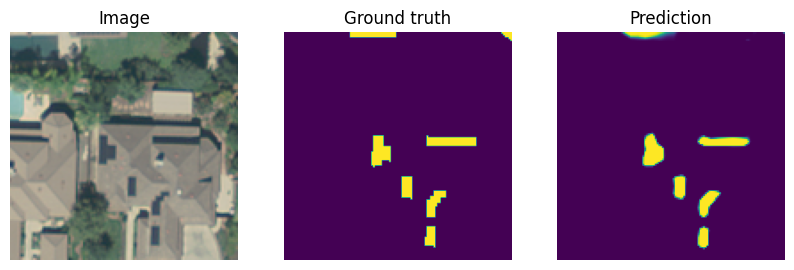

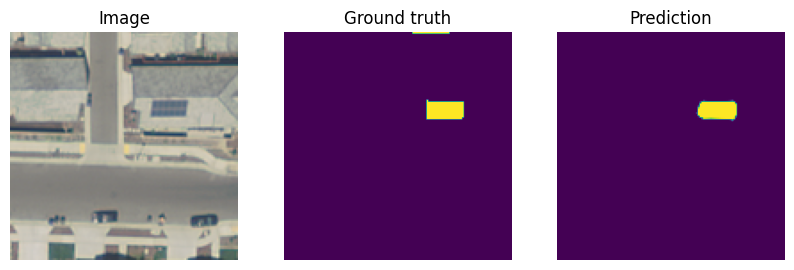

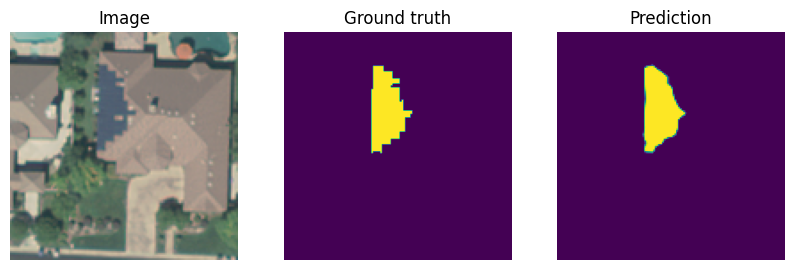

In [18]:
images, masks = next(iter(cal_test_loader))
with torch.no_grad():
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

In [9]:
cp_train_dataset = Dataset(
    cp_x_train_dir,
    cp_y_train_dir,
    augmentation=get_training_augmentation(cp_tile_size),
    classes=CLASSES,
)

cp_valid_dataset = Dataset(
    cp_x_valid_dir,
    cp_y_valid_dir,
    augmentation=get_validation_augmentation(cp_tile_size),
    classes=CLASSES,
)

cp_test_dataset = Dataset(
    cp_x_test_dir,
    cp_y_test_dir,
    augmentation=get_validation_augmentation(cp_tile_size),
    classes=CLASSES,
)

cp_train_loader = DataLoader(cp_train_dataset, batch_size=32, shuffle=True, num_workers=4)
cp_valid_loader = DataLoader(cp_valid_dataset, batch_size=32, shuffle=False, num_workers=4)
cp_test_loader = DataLoader(cp_test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [21]:
# Let's see how the trained model with the california dataset performs on the cape town one 
test_metrics = trainer.test(model, dataloaders=cp_test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]
[{'test_per_image_iou': 0.21968697011470795, 'test_dataset_iou': 0.2871120572090149}]


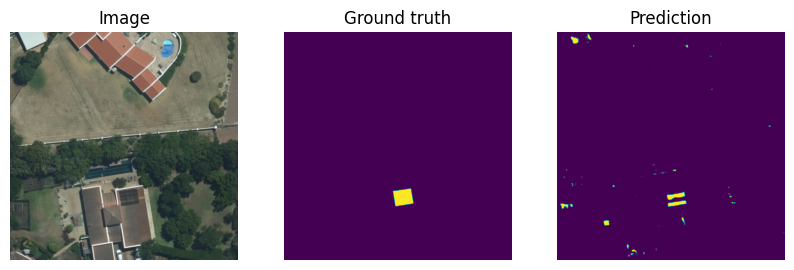

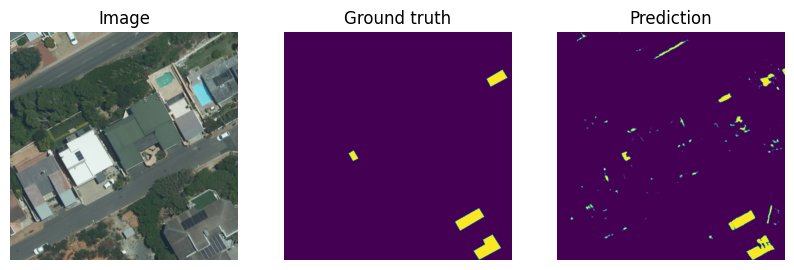

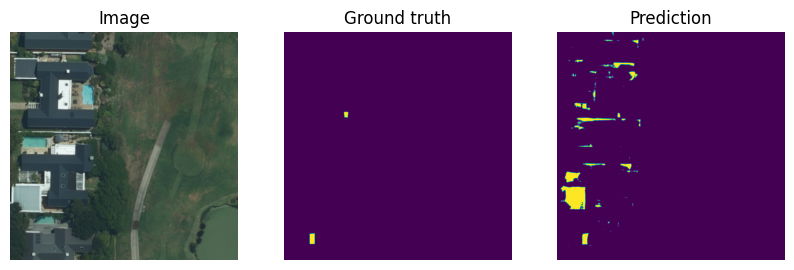

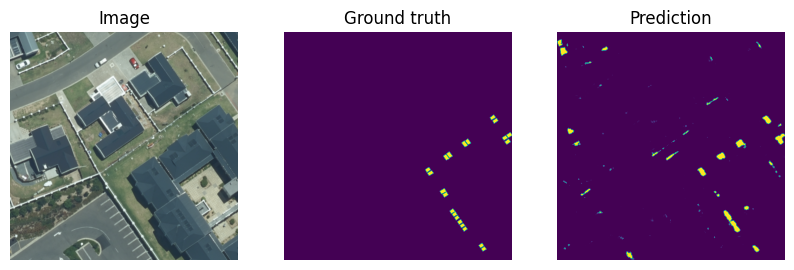

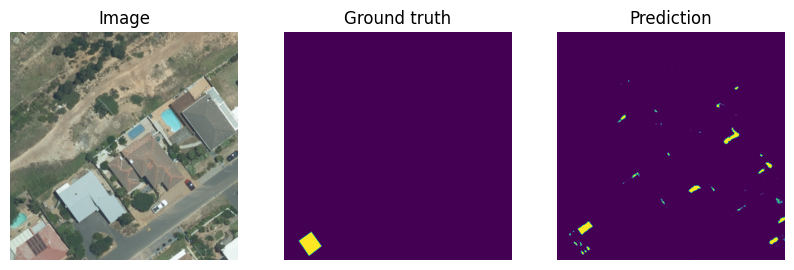

In [22]:
images, masks = next(iter(cp_test_loader))
with torch.no_grad():
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

## Fine tuning on the Cape Town dataset

The results are not so good. We need to fine tune the model on the cape town dataset.

In [10]:
EPOCHS = 15
T_MAX = EPOCHS * len(cp_train_loader) 
OUT_CLASSES = 1

In [16]:
model = SolarModel.load_from_checkpoint(
    checkpoint_path="/home/as1233/SolarDetection/trained_models/solar_model_checkpoint_124/epoch=0-val_loss=0.00.ckpt",
    arch='FPN',
    encoder_name='resnext50_32x4d',
    in_channels=3,
    out_classes=OUT_CLASSES,
    T_max = T_MAX
)

In [18]:
checkpoint_callback = ModelCheckpoint(
    dirpath='/home/as1233/SolarDetection/trained_models/solar_model_checkpoint_124_fine_tuned',   
    filename='{epoch}-{val_loss:.2f}',  
    monitor='valid_dataset_iou',                
    save_top_k=1,                       
    mode='min',                         
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]  
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


run the python script instead

In [ ]:
trainer.fit(
    model,
    train_dataloaders=cp_train_loader,
    val_dataloaders=cp_valid_loader,
)

2024-12-04 22:09:57.413078: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 22:09:57.485763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 22:09:59.390027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------

Epoch 0:   0%|          | 0/42 [00:00<?, ?it/s]                            

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 23.64 GiB of which 877.56 MiB is free. Including non-PyTorch memory, this process has 22.78 GiB memory in use. Of the allocated memory 21.61 GiB is allocated by PyTorch, and 1004.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

Since I can only train with one GPU on the notebook, I switched to a python script to train the model on the Cape Town dataset.

In [ ]:
# import torch
# from torchvision import transforms
# from PIL import Image

# # Load and preprocess the image
# image_path = '/home/as1233/data/tile_42_36.png'
# image = Image.open(image_path)
# preprocess = transforms.Compose([
#     transforms.ToTensor(), 
# ])
# image = preprocess(image).unsqueeze(0)  # Add batch dimension

# with torch.no_grad():
#     logits = saved_model(image)
#     pr_mask = logits.sigmoid()

# pr_mask = pr_mask.cpu().squeeze(0)
# pr_mask = pr_mask.numpy()

# plt.imshow(pr_mask.squeeze())
# plt.title("Prediction")
# plt.axis("off")
# plt.show()